# Part 1: Set up the simulation

In [2]:
#code heavily modified from this example:
#http://www.simpetus.com/projects.html#mpb_waveguide

import meep as mp
from meep import mpb

resolution = 100  # pixels/um # dy = 10 nm
#note that MEEP/MPB only allows for uniform mesh

#let's try to keep all the stuff that MPB spews out into 
#  standard output to a minimum
mp.quiet(True)
mp.verbosity(0)

## Define geometry:
### Just a bog standard Rib WG - geometry and number of bands

In [3]:
#all dimensions in microns

wstrip = 0.50  # Si width                                                                                                                                          
wrib   = 2.0
hstrip = 0.22  # Si height
hrib   = 0.11

#need to define supercell along dimensions for 
#  which there is no periodicity (or light propagation)
sc_y = 10  # supercell width
sc_z = 10  # supercell height
#propagation direction is x, cross-sectional axes are y,z

geometry_lattice = mp.Lattice(size=mp.Vector3(0,sc_y,sc_z))

# just assume non-dispersive medium:
Si = mp.Medium(index=3.476)
SiO2 = mp.Medium(index=1.445)

geometry = [
    mp.Block(size=mp.Vector3(mp.inf, mp.inf, mp.inf),
             center=mp.Vector3(), material=SiO2),   #SiO2 cladding everywhere
    mp.Block(size=mp.Vector3(mp.inf, wstrip, hstrip),
             center=mp.Vector3(), material=Si),     # strip part
    mp.Block(size=mp.Vector3(mp.inf, wrib, hrib),
             center=mp.Vector3(0,0,-0.5*hstrip+0.5*hrib), material=Si),     # rib part/partial etch
]


# Check the geometry
### Let's draw out the index profile of the  waveguide to ensure we're specifying the right geometry

Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 1000 x 1000.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.055)
          size (1e+20,2,0.11)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 0.0>
elapsed time for initialization: 0.779071569442749
solve_kpo

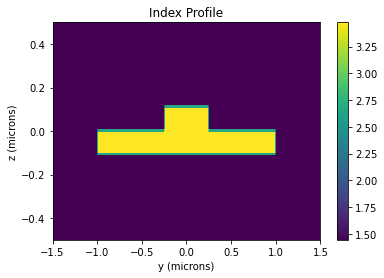

In [59]:
import numpy as np
import matplotlib.pyplot as plt


#let's do a dummy-solve of the bands.... 
num_bands = 1 # ... 1 band 
k_points = [mp.Vector3(0)] # ... 1 k-point

#... so that we can initialize the ms system
ms = mpb.ModeSolver(geometry_lattice = geometry_lattice,
                    geometry = geometry,
                    k_points = k_points,
                    resolution = resolution, # given in very first cell 
                    num_bands = num_bands)

ms.run(mpb.display_yparities)


# draw epsilon:
md = mpb.MPBData(rectify=True, periods=1, resolution=50)
eps = ms.get_epsilon()

x = np.arange(eps.shape[0])/resolution
x = x-x[int(len(x)*0.5)]

y = np.arange(eps.shape[1])/resolution
y = y-y[int(len(y)*0.5)]

IndexProfile = np.sqrt(eps.T)

plt.pcolormesh(x,y,IndexProfile)
plt.xlabel('y (microns)')
plt.ylabel('z (microns)')
plt.ylim([-0.5, 0.5])
plt.xlim([-1.5, 1.5])
plt.title('Index Profile')
plt.colorbar()

#let's get an outline for the shape:
#the outline should be where MPB uses sub-pixel sampling
WaveguideOutline = np.array((1.445<IndexProfile) & (IndexProfile<3.476), dtype = np.float)

WaveguideOutline[WaveguideOutline == 0] = 0
WaveguideOutline[WaveguideOutline == 1] = np.nan


$\uparrow$ Convention for axes:  $y-z$ axes represent the 2 transverse directions.  
Direction of propagation for eigenmode is in $x$-direction.

We observe  a gradation in index at the interface between the Silicon and SiO$_2$; MPB does what it calls a 'subpixel sampling' (basically, smearing out the index and making it continuous near the interface) to allow for better convergence of the solver.  

# Part 2: Calculate the dispersion relations (bands) for the first 4 modes...

In [4]:
num_bands = 4 

#range and number of k-points
num_k = 30
k_min = 0.5
k_max = 2.0
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

#just solve for the bands:
#no symmetries applied
ms = mpb.ModeSolver(geometry_lattice=geometry_lattice,
                    geometry=geometry,
                    k_points=k_points,
                    resolution=resolution, # given in very first cell 
                    num_bands=num_bands)

ms.run(mpb.display_yparities)
mpb.display_yparities



freqs = ms.all_freqs
print(freqs.shape)

k_points_np = [np.array(k_point) for k_point in k_points ]
k_points = np.array(k_points_np)



Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 1000 x 1000.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.055)
          size (1e+20,2,0.11)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
32 k-points
  Vector3<0.5, 0.0, 0.0>
  Vector3<0.5483870967741935, 0.0, 0.0>
  Vector3<0.5967741

## ... And plot things out again 

### Note: MEEP/MPB defines the k-vector as $k_{MEEP} \equiv \frac{n_{eff}}{\lambda}$, and frequency as $f_{MEEP}\equiv \frac{1}{\lambda}$

Text(0.5, 0, 'k/(2$\\pi$) (um$^{-1}$)')

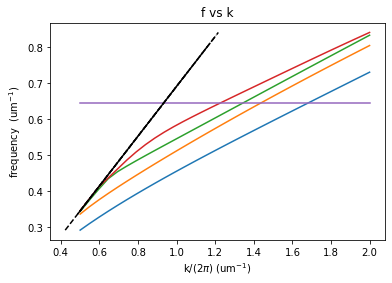

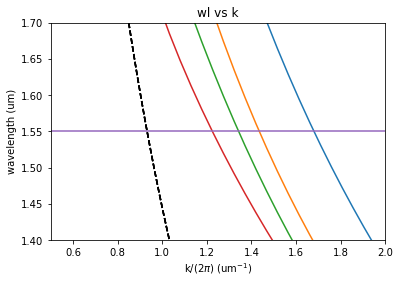

In [5]:

plt.figure()
plt.title('f vs k')
plt.plot(k_points[:,0], freqs)
plt.plot(k_points[:,0], k_points[:,0]*0 +1/1.55)# where is 1550 nm?
plt.plot(1.445*freqs, freqs, 'k--') ## light cone

plt.ylabel('frequency  (um$^{-1}$)')
plt.xlabel('k/(2$\pi$) (um$^{-1}$)')


plt.figure()
plt.title('wl vs k')
plt.plot(k_points[:,0], 1/freqs)
plt.plot(k_points[:,0], k_points[:,0]*0 +1.55) # where is 1550 nm?
plt.plot(1.445*freqs, 1/freqs, 'k--')# light cone... essentially any modes residing with effective index = cladding
plt.ylim([1.4, 1.7])
plt.xlim([0.5, 2])
plt.ylabel('wavelength (um)')
plt.xlabel('k/(2$\pi$) (um$^{-1}$)')


#Meep defines k := neff/lambda  
# frequency := 1/lambda 

### Let's get the effective indices of the 4 guided modes at $\sim$1550 nm from the above band diagrams

In [6]:
# give me the effective indices

nSiO2 = np.sqrt(SiO2.epsilon(1/1.55)[0,0]) #guiding mode should have effect index greater than this

for band in range(4):
    #print(  1/freqs[:,band]  )        
    ind = np.argmin(abs((1/freqs[:,band]) - 1.55))
    #print(ind)
    wl_actual = 1/freqs[ind,band]
    n_eff = (k_points[ind, 0] * wl_actual) # k is normalized as simply n_eff/lambda
    if (n_eff>nSiO2):
        print('%4.2f nm: n_eff = %2.3f'%(wl_actual*1e3,n_eff))       

1562.11 nm: n_eff = 2.595
1561.04 nm: n_eff = 2.216
1563.75 nm: n_eff = 2.068
1549.31 nm: n_eff = 1.899


 # Find fundamental mode effective index at 1550 nm

In [7]:

f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
# we're only looking for 1 band:s
band_min = 1
band_max = 1
kdir = mp.Vector3(1,0,0)
tol = 1e-7
#effective index is somewhere between cladding (1.445, SiO2) and core (3.476, Si)
kmag_guess = f_mode*(1.445+3.5)*0.5
kmag_min = f_mode*1.445 
kmag_max = f_mode*3.5

#how to decrease the amount of verbosity?  
mp.verbosity(verbose_val = False)


#mp.ODD_Y for Rib TE0  # fundamental mode
#mp.EVEN_Y for Rib TE1 # first excited mode

#you cannot impose more than 1 symmetry on eigensolver

k_value_Fund = ms.find_k( mp.ODD_Y, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.display_group_velocities)

k_value_FirstEx = ms.find_k( mp.EVEN_Y, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.display_group_velocities)

#effective index of fundamental mode 
n_eff_Fund = k_value_Fund[0]/f_mode
n_eff_FirstEx = k_value_FirstEx[0]/f_mode


print('Fundamental Mode effective index: %2.4f'%(n_eff_Fund))
print('First Higher order mode effective index: %2.4f'%(n_eff_FirstEx))

Initializing fields to random numbers...
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 1000 x 1000.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.055)
          size (1e+20,2,0.11)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Solving for band polarization: yodd.
1 k-points
  Vector3<1.5951612903225807, 0.0, 0.0>
elapsed time for initialization: 0.7548003196716309
solve_kpoi

# Part 4: Calculate mode profile of fundamental mode:

In [61]:
%rm e.*.h5  # delete all E-field profiles 
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time


f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 1
kdir = mp.Vector3(1,0,0)  # direction of propagation
tol = 1e-7  # when do we stop the iterative solver? 

#guess the effective index of the mode:
kmag_guess = f_mode*(1.445+3.5)*0.5
kmag_min = f_mode*1.445
kmag_max = f_mode*3.5


k_value_Fund = ms.find_k( mp.ODD_Y, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.display_group_velocities)


#outputs e-fields to hdf5 files 
mpb.output_efield_x(ms, which_band = 1)
mpb.output_efield_y(ms, which_band = 1)
mpb.output_efield_z(ms, which_band = 1)


f = h5py.File('e.k01.b01.x.yodd.h5', 'r'); ReEx = f['x.r'][()]; ImEx = f['x.i'][()]#**2 + f['x.i'][()]**2
f = h5py.File('e.k01.b01.y.yodd.h5', 'r'); ReEy = f['y.r'][()]; ImEy = f['y.i'][()]#**2 + f['y.i'][()]**2
f = h5py.File('e.k01.b01.z.yodd.h5', 'r'); ReEz = f['z.r'][()]; ImEz = f['z.i'][()]#**2 + f['z.i'][()]**2

dy = 1/resolution; dz = 1/resolution

y = np.arange(-0.5*sc_y, 0.5*sc_y, dy);  z = np.arange(-0.5*sc_z, 0.5*sc_z, dz);






Initializing fields to random numbers...
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 1000 x 1000.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.055)
          size (1e+20,2,0.11)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Solving for band polarization: yodd.
1 k-points
  Vector3<1.5951612903225807, 0.0, 0.0>
elapsed time for initialization: 0.7638869285583496
solve_kpoi

## ... and plot it out!

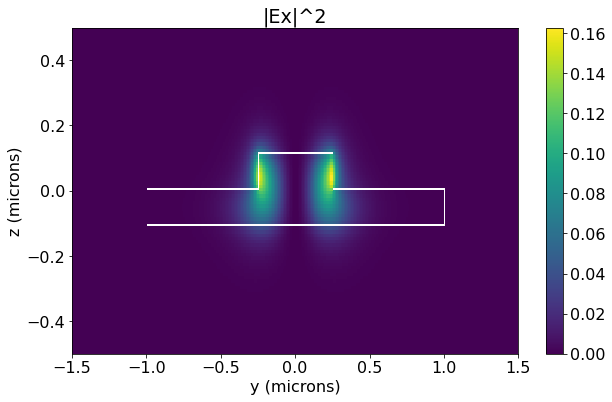

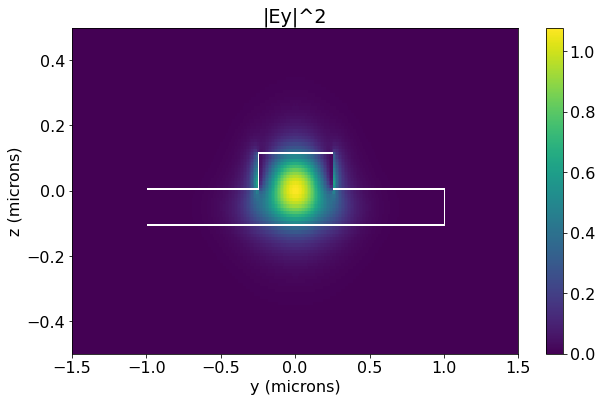

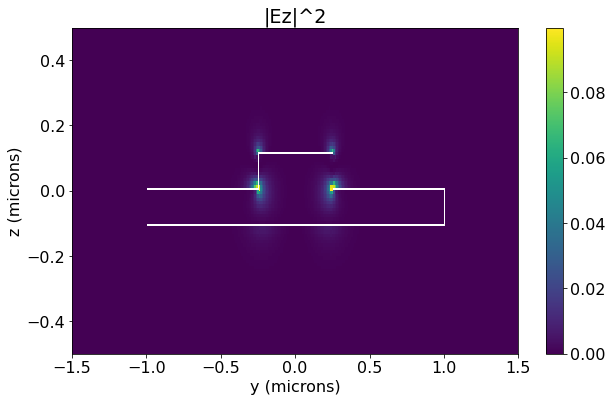

In [62]:
#plot them out

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

for polarization in ['x', 'y', 'z']:
    f = h5py.File('e.k01.b01.%s.yodd.h5'%(polarization), 'r'); 
    ReE = f['%s.r'%(polarization)][()]; ImE = f['%s.i'%(polarization)][()];

    
    Esquared = ReE**2 + ImE**2
    minE = min(np.min(ReE), np.min(ImE))
    maxE = max(np.max(ReE), np.max(ImE))

    
    plt.figure(figsize = (10,6))
    plt.pcolormesh(y, z, Esquared.T + WaveguideOutline );  #include outline
    plt.colorbar()
    plt.title('|E%s|^2'%(polarization))
    plt.xlim([-1.5, 1.5]); plt.ylim([-0.5, 0.5]); 
    plt.xlabel('y (microns)');  plt.ylabel('z (microns)');
    




$\uparrow$ We imposed anti-symmetric boundary conditions at $y = 0$.  Note how the tangential field components $E_z$, $E_x$ are both zero at the boundary. 

# Find first excited mode effective index and show eigenmode profile

In [63]:
f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 1
kdir = mp.Vector3(1)
tol = 1e-6
kmag_guess = f_mode*0.5*(3.5+1.445)
kmag_min = f_mode*1.445
kmag_max = f_mode*3.5


k_value_FirstEx = ms.find_k( mp.EVEN_Y, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.display_group_velocities)

print('neff_FirstEx = ', k_value_FirstEx[0]/f_mode)

%rm e*yeven*.h5  # delete all E-field profiles 




mpb.output_efield_x(ms, which_band = 1)
mpb.output_efield_y(ms, which_band = 1)
mpb.output_efield_z(ms, which_band = 1)


f = h5py.File('e.k01.b01.x.yeven.h5', 'r'); ReEx = f['x.r'][()]; ImEx = f['x.i'][()]#**2 + f['x.i'][()]**2
f = h5py.File('e.k01.b01.y.yeven.h5', 'r'); ReEy = f['y.r'][()]; ImEy = f['y.i'][()]#**2 + f['y.i'][()]**2
f = h5py.File('e.k01.b01.z.yeven.h5', 'r'); ReEz = f['z.r'][()]; ImEz = f['z.i'][()]#**2 + f['z.i'][()]**2



Initializing fields to random numbers...
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 1000 x 1000.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.5,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.055)
          size (1e+20,2,0.11)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 11 object nodes (vs. 3 actual objects)
Initializing epsilon function...
Solving for band polarization: yeven.
1 k-points
  Vector3<1.5951612903225807, 0.0, 0.0>
elapsed time for initialization: 0.7521111965179443
solve_kpo

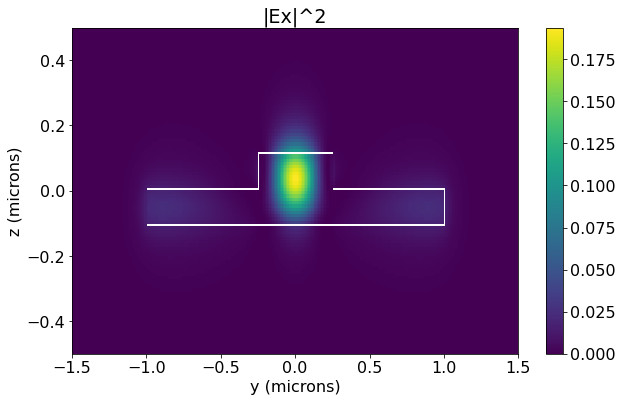

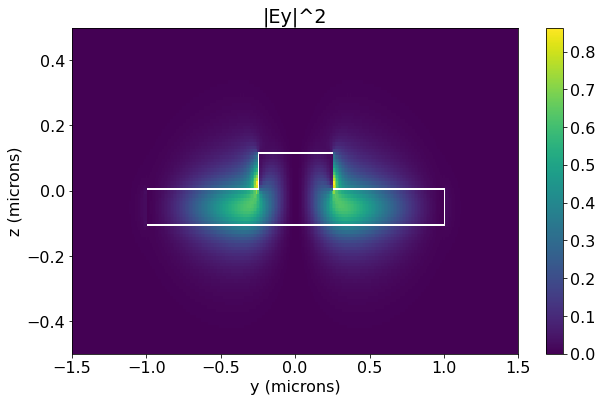

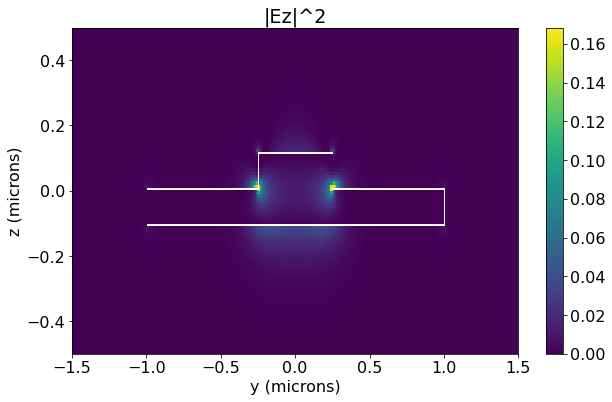

In [64]:
# for polarization in ['x', 'y', 'z']:
#     f = h5py.File('e.k01.b01.%s.yeven.h5'%(polarization), 'r'); 
#     ReE = f['%s.r'%(polarization)][()]; ImE = f['%s.i'%(polarization)][()];

#     minE = min(np.min(ReE), np.min(ImE))
#     maxE = max(np.max(ReE), np.max(ImE))
   
    
#     plt.figure(figsize = (12,3)); plt.subplot(121) 
#     plt.pcolormesh(y, z,ReE.T); 
#     plt.colorbar()
#     plt.title('Re(E%s)'%(polarization))
    
#     plt.xlim([-1.5, 1.5]); plt.ylim([-0.5, 0.5]); plt.xlabel('y');  plt.ylabel('z');
#     plt.subplot(122)
#     plt.pcolormesh(y, z,ImE.T); plt.colorbar(); plt.title('Im(E%s)'%(polarization))
#     plt.xlim([-1.5, 1.5]); plt.ylim([-0.5, 0.5]); plt.xlabel('y');  plt.ylabel('z');


#plot them out

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

for polarization in ['x', 'y', 'z']:
    f = h5py.File('e.k01.b01.%s.yeven.h5'%(polarization), 'r'); 
    ReE = f['%s.r'%(polarization)][()]; ImE = f['%s.i'%(polarization)][()];

    
    Esquared = ReE**2 + ImE**2
    minE = min(np.min(ReE), np.min(ImE))
    maxE = max(np.max(ReE), np.max(ImE))

    
    plt.figure(figsize = (10,6))
    plt.pcolormesh(y, z, Esquared.T  + WaveguideOutline);  #include the outline
    plt.colorbar()
    plt.title('|E%s|^2'%(polarization))
    plt.xlim([-1.5, 1.5]); plt.ylim([-0.5, 0.5]); 
    plt.xlabel('y (microns)');  plt.ylabel('z (microns)');



$\uparrow$ In order to find the first excited mode's profile, we imposed symmetric boundary conditions at $y = 0$.  Note how the normal  component ($E_y$) is zero at the boundary. 